Team Gordon

Student Name	Student Number
 Alisha Sahota	20497348
 Anthony Ramelo	20499391
 Chris Wu	10182394
 Elizabeth Zhang	20161231
 Emily Zhao	10096273
 Sam Hossain	20466500


Number of PCA components selected to retain 90.0% variance: 11
Explained variance by PCA components:
[0.20588808 0.1232929  0.09359682 0.09080663 0.07599469 0.06919693
 0.06422346 0.061601   0.05819494 0.04898267 0.04195218]
Silhouette Score for k=2: 0.1607
Silhouette Score for k=3: 0.1763
Silhouette Score for k=4: 0.1885
Silhouette Score for k=5: 0.2065
Silhouette Score for k=6: 0.1664
Silhouette Score for k=7: 0.1568
Silhouette Score for k=8: 0.2071
Silhouette Score for k=9: 0.1914
Silhouette Score for k=10: 0.1991
Optimal number of clusters: 8
Highest Silhouette Score: 0.2071
Clustered data saved to output/final_output_with_clusters.csv


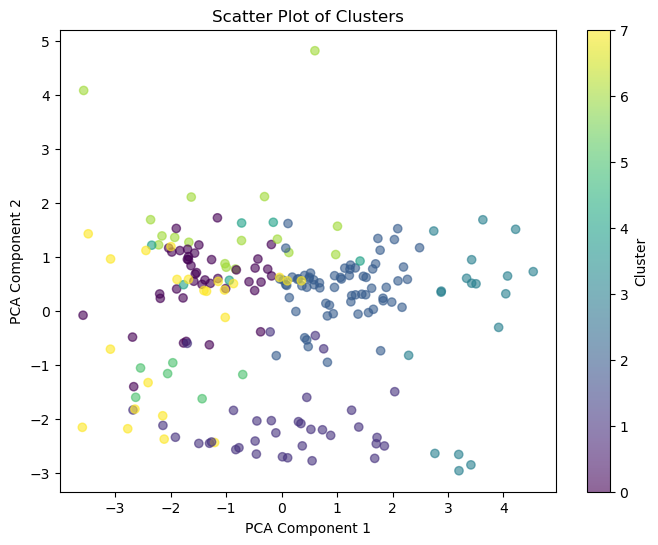

Scatter plot saved to output/scatter_plot_clusters.png


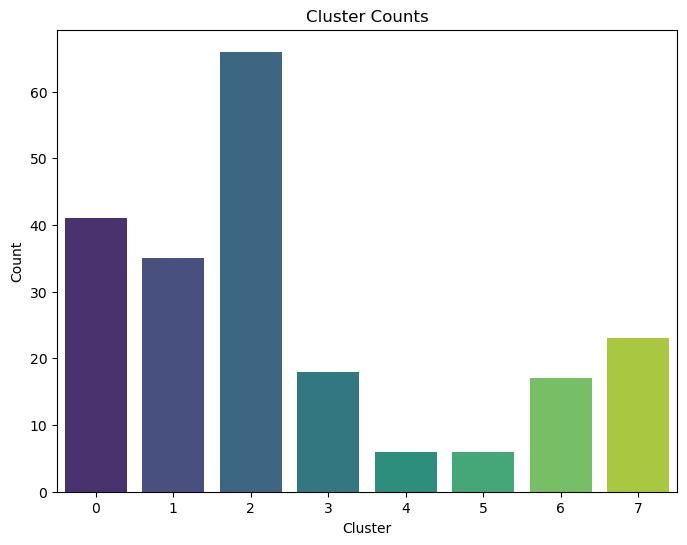

Cluster counts plot saved to output/cluster_counts.png


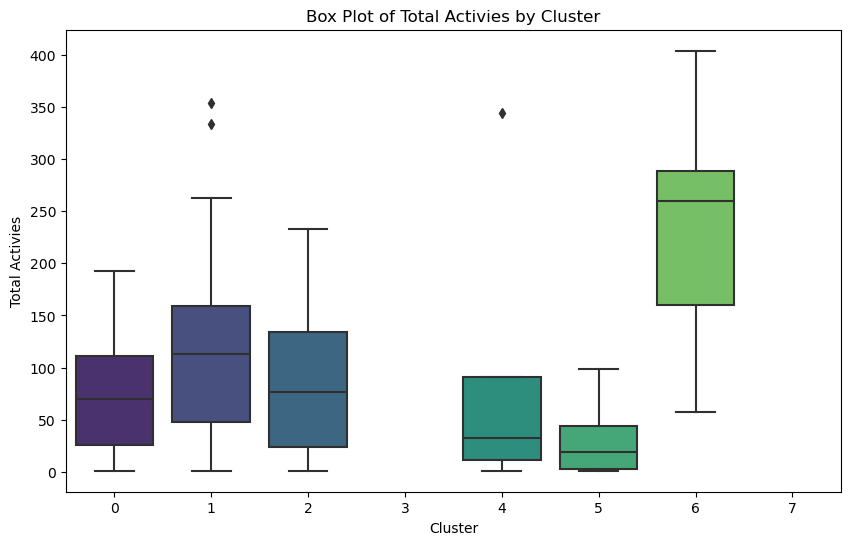

Box plot saved to output/boxplot_total_activities_by_cluster.png


In [16]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def load_data(file_path, sheet_name):
    """
    Load data from an Excel file and strip column names.
    """
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    df.columns = df.columns.str.strip()  # Remove extra spaces
    return df

def ensure_column_exists(df, column_name, alternative_names=None):
    """
    Ensure that a column exists in the DataFrame, optionally checking alternative names.
    """
    if column_name in df.columns:
        return column_name
    elif alternative_names:
        for alt_name in alternative_names:
            if alt_name in df.columns:
                return alt_name
    raise ValueError(f"Column '{column_name}' or alternatives {alternative_names} not found.")

def preprocess_data(df, total_activities_col, columns_to_remove):
    """
    Preprocess the data by dropping unnecessary columns, handling missing values,
    encoding categorical variables, and scaling features.
    """
    # Drop rows with missing 'Total Activities'
    # df = df[df[total_activities_col].notna()]
    
    # Save the ID column separately for reference
    df['ID'] = df['ID'].astype(str)
    
    # Preserve original dataset for reference
    df_original = df.copy()
    
    # Remove unnecessary columns
    existing_columns_to_remove = [col for col in columns_to_remove if col in df.columns]
    df = df.drop(columns=existing_columns_to_remove)
    
    # Drop columns with more than 50% missing data
    threshold = len(df) * 0.5
    df = df.dropna(thresh=threshold, axis=1)
    
    # Handle missing values
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    categorical_cols = df.select_dtypes(include=['object']).columns
    
    imputer_num = SimpleImputer(strategy='mean')
    imputer_cat = SimpleImputer(strategy='most_frequent')
    
    if not numeric_cols.empty:
        df[numeric_cols] = pd.DataFrame(
            imputer_num.fit_transform(df[numeric_cols]),
            columns=numeric_cols,
            index=df.index
        )
    
    if not categorical_cols.empty:
        df[categorical_cols] = pd.DataFrame(
            imputer_cat.fit_transform(df[categorical_cols]),
            columns=categorical_cols,
            index=df.index
        )
    
    # Encode categorical variables
    df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
    
    # Scale the features
    scaler = StandardScaler()
    df_encoded[df_encoded.columns] = scaler.fit_transform(df_encoded)
    
    return df_encoded, df_original

def perform_pca(df_encoded, variance_threshold=0.9):
    """
    Perform PCA on the encoded data to reduce dimensionality while retaining specified variance.
    """
    pca = PCA(n_components=variance_threshold, random_state=42)
    df_pca = pd.DataFrame(pca.fit_transform(df_encoded))
    print(f"Number of PCA components selected to retain {variance_threshold*100}% variance: {df_pca.shape[1]}")
    print("Explained variance by PCA components:")
    print(pca.explained_variance_ratio_)
    return df_pca

def determine_optimal_clusters(df_pca, k_range=range(2, 11)):
    """
    Determine the optimal number of clusters using the silhouette score.
    """
    silhouette_scores = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        labels = kmeans.fit_predict(df_pca)
        silhouette_avg = silhouette_score(df_pca, labels)
        silhouette_scores.append(silhouette_avg)
        print(f"Silhouette Score for k={k}: {silhouette_avg:.4f}")
    
    optimal_k = k_range[silhouette_scores.index(max(silhouette_scores))]
    print(f"Optimal number of clusters: {optimal_k}")
    print(f"Highest Silhouette Score: {max(silhouette_scores):.4f}")
    return optimal_k

def perform_clustering(df_pca, df_original, optimal_k):
    """
    Perform KMeans clustering with the optimal number of clusters and assign cluster labels.
    """
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
    df_original['Cluster'] = kmeans.fit_predict(df_pca)
    return df_original

def save_clustered_data(df_original, output_dir="output", filename="final_output_with_clusters.csv"):
    """
    Save the clustered dataset to a CSV file.
    """
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, filename)
    df_original.to_csv(output_path, index=False)
    print(f"Clustered data saved to {output_path}")

def plot_clusters(df_pca, df_original, total_activities_col, output_dir="output"):
    """
    Create and save cluster visualization plots.
    """
    os.makedirs(output_dir, exist_ok=True)
    
    # Scatter Plot of Clusters
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(df_pca.iloc[:, 0], df_pca.iloc[:, 1], c=df_original['Cluster'], cmap='viridis', alpha=0.6)
    plt.title('Scatter Plot of Clusters')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.colorbar(scatter, label='Cluster')
    scatter_plot_path = os.path.join(output_dir, "scatter_plot_clusters.png")
    plt.savefig(scatter_plot_path)
    plt.show()
    print(f"Scatter plot saved to {scatter_plot_path}")
    
    # Cluster Counts
    plt.figure(figsize=(8, 6))
    cluster_counts = df_original['Cluster'].value_counts().sort_index()
    sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')
    plt.title('Cluster Counts')
    plt.xlabel('Cluster')
    plt.ylabel('Count')
    cluster_counts_path = os.path.join(output_dir, "cluster_counts.png")
    plt.savefig(cluster_counts_path)
    plt.show()
    print(f"Cluster counts plot saved to {cluster_counts_path}")
    
    # Box Plot of Total Activities by Cluster
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_original, x='Cluster', y=total_activities_col, palette='viridis')
    plt.title(f'Box Plot of {total_activities_col} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(total_activities_col)
    boxplot_path = os.path.join(output_dir, "boxplot_total_activities_by_cluster.png")
    plt.savefig(boxplot_path)
    plt.show()
    print(f"Box plot saved to {boxplot_path}")

def main():
    # File and sheet details
    file_path = 'Data 3 - October, 2024.xlsx'
    sheet_name = 'Parachute - Cross Section'
    
    # Load the data
    df = load_data(file_path, sheet_name)
    
    # Ensure "Total Activities" column exists
    total_activities_col = ensure_column_exists(df, 'Total Activities', alternative_names=['Total Activies'])
    
    # Columns to remove
    columns_to_remove = [
        "Aptitude for change Score", "Financial Literacy Score", "Self Assessments", "Quiz Count", "Mood Count",
        "Inspiration Count", "Average total activities per month", "Average activities per day", "Disbursement Date",
        "Province", "Loan Payment Type", "Loan Maturity Date", "City", "Postal Code", "Date of Birth", "ID"
    ]
    
    # Preprocess the data
    df_encoded, df_original = preprocess_data(df, total_activities_col, columns_to_remove)
    
    # Perform PCA
    df_pca = perform_pca(df_encoded, variance_threshold=0.9)
    
    # Determine optimal number of clusters
    optimal_k = determine_optimal_clusters(df_pca, k_range=range(2, 11))
    
    # Perform clustering
    df_clustered = perform_clustering(df_pca, df_original, optimal_k)
    
    # Save the clustered dataset
    save_clustered_data(df_clustered)
    
    # Visualizations
    plot_clusters(df_pca, df_clustered, total_activities_col)

if __name__ == "__main__":
    main()